In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline 
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10,6
import os

In [59]:
list1=[]
TARGET_DATE_LIST=[]
for DATE in range(17,23):
    TARGET_DATE_LIST.append('2018-04-' + str(DATE).zfill(2))
for date in TARGET_DATE_LIST:
    taget_date_files = os.listdir(date)
    for filename in taget_date_files:
        taget_date_dir = os.path.join(date, filename)
        df = np.load(taget_date_dir)[65:75,65:75].reshape([1, 100]) 
        df = pd.DataFrame(df)
        list1.append(df)
a=pd.concat(list1)

In [60]:
a.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,12.0,12.0,87.0,41.0,9.0,28.0,1.0,8.0,1.0,12.0,...,15.0,2.0,5.0,79.0,38.0,11.0,33.0,1.0,4.0,2.0
0,13.0,41.0,45.0,29.0,7.0,10.0,5.0,6.0,6.0,17.0,...,9.0,1.0,5.0,76.0,52.0,11.0,32.0,4.0,6.0,6.0
0,10.0,26.0,49.0,29.0,14.0,10.0,3.0,6.0,3.0,11.0,...,7.0,1.0,1.0,45.0,28.0,7.0,27.0,3.0,5.0,5.0
0,7.0,21.0,38.0,19.0,10.0,12.0,1.0,10.0,1.0,15.0,...,0.0,1.0,1.0,20.0,36.0,8.0,17.0,2.0,8.0,3.0
0,4.0,29.0,32.0,27.0,8.0,9.0,2.0,6.0,2.0,3.0,...,8.0,2.0,1.0,27.0,39.0,4.0,12.0,0.0,4.0,1.0


In [61]:
a = np.array(a)

In [5]:
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import glob
from datetime import datetime
from tensorflow.keras.callbacks import EarlyStopping
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score

In [7]:
train_size = int(len(a) * 0.90)
test_size = len(a) - train_size
train, test = a[0:train_size], a[train_size:]
print(len(train), len(test))

259 29


In [8]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import math
from tensorflow import keras
import numpy as np
import pandas as pd

In [92]:
class TimeBlock(tf.keras.Model):
    def __init__(self, kernel_size, out_channels):
        super(TimeBlock, self).__init__(name='')
        self.conva = tf.keras.layers.Conv1D(out_channels, kernel_size)
        self.convb = tf.keras.layers.Conv1D(out_channels, kernel_size)
        self.convc = tf.keras.layers.Conv1D(out_channels, kernel_size)
        
    def __call__(self, X):
        temp = self.conva(X) + tf.sigmoid(self.convb(X))
        out = tf.nn.relu(temp + self.convc(X))
        return out

In [117]:
class GeoBlock(tf.keras.Model):

    def __init__(self, spatial_channels, out_channels, A_hat):
        super(GeoBlock, self).__init__()
        self.kernel = self.add_variable("kernel", shape=[out_channels, spatial_channels],
                                        initializer=tf.initializers.RandomUniform(-1/4, 1/4))
        self.A_hat=A_hat

    def __call__(self, X):
        """
        :param X: Input data of shape (batch_size, num_nodes, num_timesteps,
        num_features=in_channels).
        :param A_hat: Normalized adjacency matrix.
        :return: Output data of shape (batch_size, num_nodes,
        num_timesteps_out, num_features=out_channels).
        """
        
        lfs = tf.einsum("ij,jklm->kilm", A_hat, X)
        t2 = tf.nn.relu(tf.linalg.matmul(lfs, self.kernel))
        return t2
        # return t3


In [74]:
import os
import zipfile
import numpy as np
import torch


def get_normalized_adj(A):
    """
    Returns the degree normalized adjacency matrix.
    """
    A = A + np.diag(np.ones(A.shape[0], dtype=np.float32))
    D = np.array(np.sum(A, axis=1)).reshape((-1,))
    D[D <= 10e-5] = 10e-5    # Prevent infs
    diag = np.reciprocal(np.sqrt(D))
    A_wave = np.multiply(np.multiply(diag.reshape((-1, 1)), A),
                         diag.reshape((1, -1)))
    return A_wave


def generate_dataset(X, num_timesteps_input, num_timesteps_output):
    """
    Takes node features for the graph and divides them into multiple samples
    along the time-axis by sliding a window of size (num_timesteps_input+
    num_timesteps_output) across it in steps of 1.
    :param X: Node features of shape (num_vertices, num_features,
    num_timesteps)
    :return:
        - Node features divided into multiple samples. Shape is
          (num_samples, num_vertices, num_features, num_timesteps_input).
        - Node targets for the samples. Shape is
          (num_samples, num_vertices, num_features, num_timesteps_output).
    """
    # Generate the beginning index and the ending index of a sample, which
    # contains (num_points_for_training + num_points_for_predicting) points
    indices = [(i, i + (num_timesteps_input + num_timesteps_output)) for i
               in range(X.shape[0] - (
                num_timesteps_input + num_timesteps_output) + 1)]

    # Save samples
    features, target = [], []
    for i, j in indices:
        features.append(X[i: i + num_timesteps_input])
        target.append(X[i + num_timesteps_input: j])

    return np.array(features), np.array(target)

In [12]:
a.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
2018-04-17-00:00:00,12.0,12.0,87.0,41.0,9.0,28.0,1.0,8.0,1.0,12.0,...,15.0,2.0,5.0,79.0,38.0,11.0,33.0,1.0,4.0,2.0
2018-04-17-00:30:00,13.0,41.0,45.0,29.0,7.0,10.0,5.0,6.0,6.0,17.0,...,9.0,1.0,5.0,76.0,52.0,11.0,32.0,4.0,6.0,6.0
2018-04-17-01:00:00,10.0,26.0,49.0,29.0,14.0,10.0,3.0,6.0,3.0,11.0,...,7.0,1.0,1.0,45.0,28.0,7.0,27.0,3.0,5.0,5.0
2018-04-17-01:30:00,7.0,21.0,38.0,19.0,10.0,12.0,1.0,10.0,1.0,15.0,...,0.0,1.0,1.0,20.0,36.0,8.0,17.0,2.0,8.0,3.0
2018-04-17-02:00:00,4.0,29.0,32.0,27.0,8.0,9.0,2.0,6.0,2.0,3.0,...,8.0,2.0,1.0,27.0,39.0,4.0,12.0,0.0,4.0,1.0


In [13]:
from sklearn.neighbors import kneighbors_graph

In [33]:
def make_matrix(rows, cols):
    n=rows*cols
    M = np.zeros([n,n])
    for r in range(rows):
        for c in range(cols):
            i = r*cols + c
            if c>0: M[i-1][i]=M[i][i-1]=1
            if r>0: M[i-cols][i]=M[i][i-cols]=1
    return M

In [107]:
A = make_matrix(10, 10)

In [35]:
A.shape

(100, 100)

In [108]:
A_hat=get_normalized_adj(A)

In [109]:
A_hat = tf.convert_to_tensor(A_hat)

In [62]:
mean = np.array(np.mean(a, axis=0))

In [63]:
mean.shape

(100,)

In [64]:
std = np.array(np.std(a, axis=0))

In [65]:
std.shape

(100,)

In [66]:
mean=mean.reshape(1,100)
std=std.reshape(1,100)

In [67]:
a = (a-mean)/std

In [69]:
a[4][1]*std[0][1]+mean[0][1]

28.999999999999993

In [138]:
num = int(0.8*len(a))
train = a[:num]
test = a[num:]
print(len(train),len(test))

230 58


In [185]:
class STGCN(tf.keras.Model):
    

    def __init__(self, A_hat):
        super(STGCN, self).__init__()
        self.block1 = TimeBlock(3, 64)
        self.block2 = GeoBlock(16,64, A_hat)
        self.block3 = TimeBlock(3, 64)

    def __call__(self, X):
        """
        :param X: Input data of shape (batch_size, num_nodes, num_timesteps,
        num_features=in_channels).
        :param A_hat: Normalized adjacency matrix.
        """
        out1 = tf.reshape(X, [-1, X.shape[-2], X.shape[-1]])
        out2 = self.block1(out1)
        out3 = tf.reshape(out2, [100, -1, out2.shape[-2],out2.shape[-1]])
        out4 = self.block2(out3)
        out5 = tf.reshape(out4, [-1, out4.shape[-2], out4.shape[-1]])
        out6 = self.block3(out5)
        out7 = tf.reshape(out6, [-1, 100, out6.shape[-2], out6.shape[-1]])
        return out7

In [187]:
STGCN1=STGCN(A_hat)
STGCN2=STGCN(A_hat)
TimeBlock1= TimeBlock(3, 64)
layer1 = tf.keras.layers.Dense(1)

In [188]:
Input = keras.Input(shape=(100,12,1),name='input')
out1 = STGCN1(Input)
out2 = STGCN2(out1)
out3 = tf.reshape(out2, [-1, out2.shape[-2], out2.shape[-1]])
out4 = TimeBlock1(out3)
out4 = tf.reshape(out4, [-1, 100, out4.shape[-2], out4.shape[-1]])
out4 = tf.reshape(out4, [-1, 100, 128])
out5 = layer1(out4)
STGCN = keras.Model(inputs=Input,outputs=out5)
STGCN.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 100, 12, 1)] 0                                            
__________________________________________________________________________________________________
tf_op_layer_Reshape_74 (TensorF [(None, 12, 1)]      0           input[0][0]                      
__________________________________________________________________________________________________
conv1d_196 (Conv1D)             (None, 10, 64)       256         tf_op_layer_Reshape_74[0][0]     
__________________________________________________________________________________________________
conv1d_195 (Conv1D)             (None, 10, 64)       256         tf_op_layer_Reshape_74[0][0]     
____________________________________________________________________________________________

                                                                 tf_op_layer_Sigmoid_24[0][0]     
__________________________________________________________________________________________________
conv1d_203 (Conv1D)             (None, 6, 64)        12352       tf_op_layer_Reshape_80[0][0]     
__________________________________________________________________________________________________
tf_op_layer_add_49 (TensorFlowO [(None, 6, 64)]      0           tf_op_layer_add_48[0][0]         
                                                                 conv1d_203[0][0]                 
__________________________________________________________________________________________________
tf_op_layer_Relu_29 (TensorFlow [(None, 6, 64)]      0           tf_op_layer_add_49[0][0]         
__________________________________________________________________________________________________
tf_op_layer_Reshape_81 (TensorF [(100, None, 6, 64)] 0           tf_op_layer_Relu_29[0][0]        
__________

Total params: 93,825
Trainable params: 93,825
Non-trainable params: 0
__________________________________________________________________________________________________


In [123]:
A_hat=tf.dtypes.cast(A_hat,dtype=np.float32)

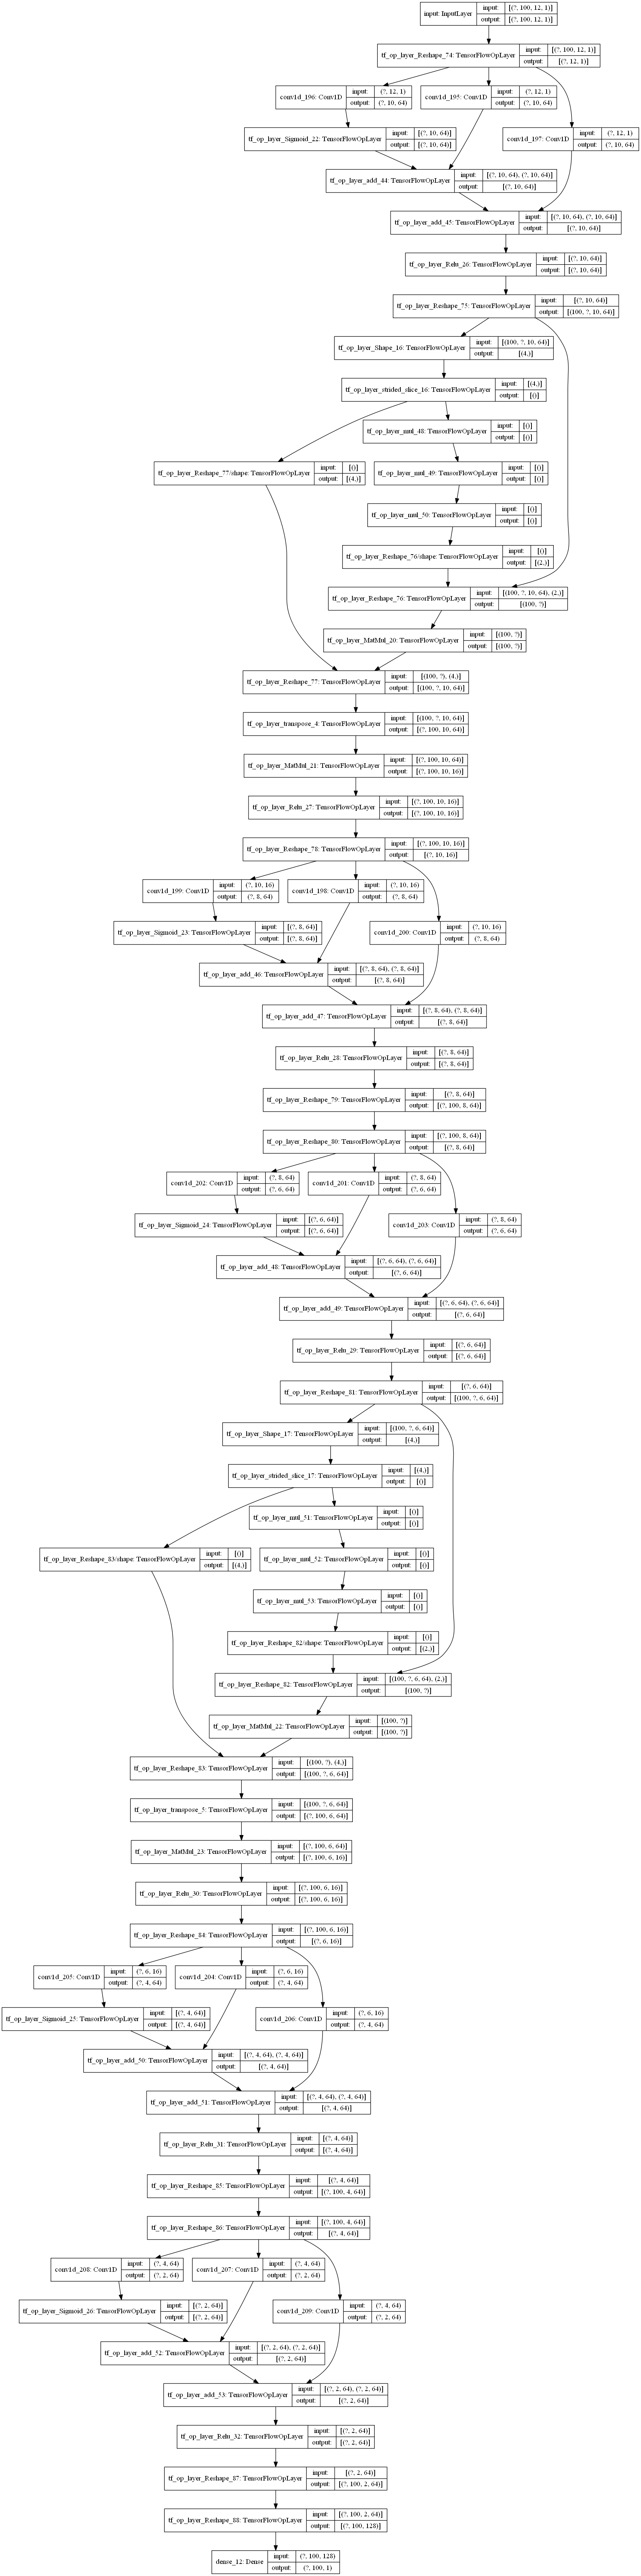

In [189]:
keras.utils.plot_model(STGCN, 'STGCN.png', show_shapes=True)

In [127]:
a

array([[-0.06636432,  0.43396641,  2.00294415, ..., -1.07736926,
        -1.08096008, -0.9081992 ],
       [ 0.01196734,  3.86624623,  0.30240281, ...,  0.30166339,
        -0.72899117, -0.18113493],
       [-0.22302762,  2.09092908,  0.46435913, ..., -0.15801416,
        -0.90497562, -0.362901  ],
       ...,
       [-0.37969093, -0.39451492, -0.50737878, ..., -0.15801416,
        -1.43292899, -1.08996526],
       [-0.30135928, -0.27616045, -0.4668897 , ..., -0.15801416,
        -1.08096008, -1.08996526],
       [-0.22302762,  0.43396641, -0.58835693, ..., -0.15801416,
        -0.90497562, -0.72643313]])

In [128]:
train

array([[-0.06636432,  0.43396641,  2.00294415, ..., -1.07736926,
        -1.08096008, -0.9081992 ],
       [ 0.01196734,  3.86624623,  0.30240281, ...,  0.30166339,
        -0.72899117, -0.18113493],
       [-0.22302762,  2.09092908,  0.46435913, ..., -0.15801416,
        -0.90497562, -0.362901  ],
       ...,
       [ 1.97025868, -0.74957835, -1.39813852, ..., -0.15801416,
        -0.55300671,  1.27299359],
       [ 1.34360545, -0.63122387, -1.19569313, ..., -1.07736926,
        -0.72899117,  0.36416326],
       [ 1.73526372, -0.9862873 , -1.15520405, ...,  2.1403736 ,
         0.15093111,  0.1823972 ]])

In [192]:
train_x, train_y = generate_dataset(train, 12, 1)
test_x, test_y = generate_dataset(test, 12, 1)
train_x = np.expand_dims(train_x, axis=3)
test_x = np.expand_dims(test_x, axis=3)

In [193]:
train_x = train_x.transpose(0, 2, 1, 3)
test_x = test_x.transpose(0, 2, 1, 3)
train_y = train_y.transpose(0, 2, 1)
test_y = test_y.transpose(0, 2, 1)

In [194]:
train_y.shape

(218, 100, 1)

In [195]:
test_y.shape

(46, 100, 1)

In [143]:
train_x.shape

(216, 12, 100, 1)

In [196]:
STGCN.compile(loss='mae', metrics=[keras.metrics.MeanAbsoluteError()],optimizer='adam')
#history = model.fit(trainX, trainY, epochs=20, batch_size=100, verbose=2)
history = STGCN.fit({'input': train_x},{'dense_12':train_y},
          epochs=30,
          batch_size=10,
          validation_data=({'input': test_x}, {'dense_12':test_y}),
          )

Train on 218 samples, validate on 46 samples
Epoch 1/30
218/218 [==============================] - ETA: 54s - loss: 2.8327 - mean_absolute_error: 2.83 - ETA: 27s - loss: 2.2592 - mean_absolute_error: 2.25 - ETA: 18s - loss: 1.8339 - mean_absolute_error: 1.83 - ETA: 13s - loss: 1.5583 - mean_absolute_error: 1.55 - ETA: 10s - loss: 1.5057 - mean_absolute_error: 1.50 - ETA: 8s - loss: 1.4396 - mean_absolute_error: 1.4396 - ETA: 7s - loss: 1.3591 - mean_absolute_error: 1.359 - ETA: 5s - loss: 1.3487 - mean_absolute_error: 1.348 - ETA: 5s - loss: 1.3031 - mean_absolute_error: 1.303 - ETA: 4s - loss: 1.2593 - mean_absolute_error: 1.259 - ETA: 3s - loss: 1.2133 - mean_absolute_error: 1.213 - ETA: 3s - loss: 1.2080 - mean_absolute_error: 1.208 - ETA: 2s - loss: 1.1870 - mean_absolute_error: 1.187 - ETA: 2s - loss: 1.1561 - mean_absolute_error: 1.156 - ETA: 1s - loss: 1.1319 - mean_absolute_error: 1.131 - ETA: 1s - loss: 1.1201 - mean_absolute_error: 1.120 - ETA: 1s - loss: 1.1058 - mean_absolu

218/218 [==============================] - ETA: 2s - loss: 0.8575 - mean_absolute_error: 0.857 - ETA: 2s - loss: 0.8273 - mean_absolute_error: 0.827 - ETA: 2s - loss: 0.8246 - mean_absolute_error: 0.824 - ETA: 2s - loss: 0.7940 - mean_absolute_error: 0.794 - ETA: 2s - loss: 0.7908 - mean_absolute_error: 0.790 - ETA: 2s - loss: 0.7915 - mean_absolute_error: 0.791 - ETA: 1s - loss: 0.7989 - mean_absolute_error: 0.798 - ETA: 1s - loss: 0.8042 - mean_absolute_error: 0.804 - ETA: 1s - loss: 0.7926 - mean_absolute_error: 0.792 - ETA: 1s - loss: 0.7887 - mean_absolute_error: 0.788 - ETA: 1s - loss: 0.7896 - mean_absolute_error: 0.789 - ETA: 1s - loss: 0.7980 - mean_absolute_error: 0.798 - ETA: 1s - loss: 0.7901 - mean_absolute_error: 0.790 - ETA: 1s - loss: 0.7917 - mean_absolute_error: 0.791 - ETA: 0s - loss: 0.7863 - mean_absolute_error: 0.786 - ETA: 0s - loss: 0.7909 - mean_absolute_error: 0.790 - ETA: 0s - loss: 0.7842 - mean_absolute_error: 0.784 - ETA: 0s - loss: 0.7818 - mean_absolute_

218/218 [==============================] - ETA: 2s - loss: 0.8036 - mean_absolute_error: 0.803 - ETA: 2s - loss: 0.7940 - mean_absolute_error: 0.794 - ETA: 2s - loss: 0.8042 - mean_absolute_error: 0.804 - ETA: 2s - loss: 0.7888 - mean_absolute_error: 0.788 - ETA: 2s - loss: 0.7923 - mean_absolute_error: 0.792 - ETA: 2s - loss: 0.7909 - mean_absolute_error: 0.790 - ETA: 1s - loss: 0.7894 - mean_absolute_error: 0.789 - ETA: 1s - loss: 0.7900 - mean_absolute_error: 0.790 - ETA: 1s - loss: 0.7888 - mean_absolute_error: 0.788 - ETA: 1s - loss: 0.7883 - mean_absolute_error: 0.788 - ETA: 1s - loss: 0.7849 - mean_absolute_error: 0.784 - ETA: 1s - loss: 0.7890 - mean_absolute_error: 0.789 - ETA: 1s - loss: 0.7896 - mean_absolute_error: 0.789 - ETA: 1s - loss: 0.7849 - mean_absolute_error: 0.784 - ETA: 0s - loss: 0.7862 - mean_absolute_error: 0.786 - ETA: 0s - loss: 0.7847 - mean_absolute_error: 0.784 - ETA: 0s - loss: 0.7859 - mean_absolute_error: 0.785 - ETA: 0s - loss: 0.7839 - mean_absolute_

218/218 [==============================] - ETA: 2s - loss: 0.8327 - mean_absolute_error: 0.832 - ETA: 2s - loss: 0.7746 - mean_absolute_error: 0.774 - ETA: 2s - loss: 0.8133 - mean_absolute_error: 0.813 - ETA: 2s - loss: 0.8176 - mean_absolute_error: 0.817 - ETA: 2s - loss: 0.8048 - mean_absolute_error: 0.804 - ETA: 2s - loss: 0.7971 - mean_absolute_error: 0.797 - ETA: 1s - loss: 0.7840 - mean_absolute_error: 0.784 - ETA: 1s - loss: 0.7877 - mean_absolute_error: 0.787 - ETA: 1s - loss: 0.7842 - mean_absolute_error: 0.784 - ETA: 1s - loss: 0.7887 - mean_absolute_error: 0.788 - ETA: 1s - loss: 0.7880 - mean_absolute_error: 0.788 - ETA: 1s - loss: 0.7863 - mean_absolute_error: 0.786 - ETA: 1s - loss: 0.7781 - mean_absolute_error: 0.778 - ETA: 1s - loss: 0.7808 - mean_absolute_error: 0.780 - ETA: 0s - loss: 0.7798 - mean_absolute_error: 0.779 - ETA: 0s - loss: 0.7812 - mean_absolute_error: 0.781 - ETA: 0s - loss: 0.7743 - mean_absolute_error: 0.774 - ETA: 0s - loss: 0.7763 - mean_absolute_

218/218 [==============================] - ETA: 2s - loss: 0.7446 - mean_absolute_error: 0.744 - ETA: 2s - loss: 0.7639 - mean_absolute_error: 0.763 - ETA: 2s - loss: 0.7567 - mean_absolute_error: 0.756 - ETA: 2s - loss: 0.7585 - mean_absolute_error: 0.758 - ETA: 2s - loss: 0.7695 - mean_absolute_error: 0.769 - ETA: 2s - loss: 0.7532 - mean_absolute_error: 0.753 - ETA: 2s - loss: 0.7536 - mean_absolute_error: 0.753 - ETA: 1s - loss: 0.7419 - mean_absolute_error: 0.741 - ETA: 1s - loss: 0.7480 - mean_absolute_error: 0.748 - ETA: 1s - loss: 0.7503 - mean_absolute_error: 0.750 - ETA: 1s - loss: 0.7571 - mean_absolute_error: 0.757 - ETA: 1s - loss: 0.7571 - mean_absolute_error: 0.757 - ETA: 1s - loss: 0.7646 - mean_absolute_error: 0.764 - ETA: 1s - loss: 0.7638 - mean_absolute_error: 0.763 - ETA: 0s - loss: 0.7676 - mean_absolute_error: 0.767 - ETA: 0s - loss: 0.7710 - mean_absolute_error: 0.771 - ETA: 0s - loss: 0.7696 - mean_absolute_error: 0.769 - ETA: 0s - loss: 0.7701 - mean_absolute_

In [197]:
history = history.history

In [198]:
history = pd.DataFrame(history)

In [165]:
import pandas as pd

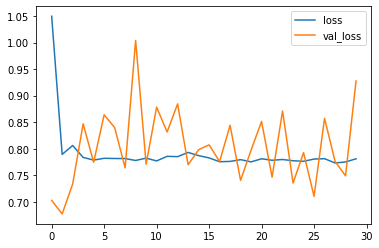

In [199]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.legend(['loss','val_loss'])

In [200]:
test_prediction = STGCN.predict({'input': test_x})

In [201]:
test_prediction.shape

(46, 100, 1)

In [202]:
test_prediction = test_prediction.reshape(46,100)*std+mean

In [203]:
test_prediction.shape

(46, 100)

In [204]:
a.shape

(288, 100)

In [205]:
test_y1 = a[-46:]

In [206]:
test_y1.shape

(46, 100)

In [207]:
test_prediction=pd.DataFrame(test_prediction)
test_y1 = pd.DataFrame(test_y1)
list=[]
for i in range(100):
    list.append(mean_squared_error(test_y1.iloc[:,i], test_prediction.iloc[:,i]))

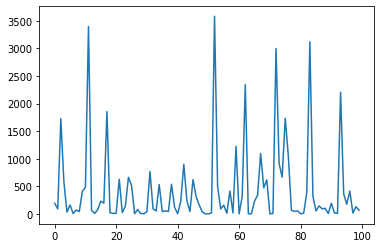

In [208]:
plt.plot(list)

In [209]:
sum(list)/len(list)

434.59433372275845

In [210]:
test_prediction

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,15.019994,9.919828,41.534453,23.552753,4.887960,11.928937,2.591673,7.667928,6.043272,20.060937,...,13.191452,4.085066,2.668348,46.258817,18.965818,12.708461,19.557175,3.633965,10.998367,7.584403
1,14.999245,9.829168,40.958133,23.043623,4.875786,11.849299,2.721242,7.906343,6.255168,20.222914,...,13.047929,4.090292,2.568157,45.899489,18.490473,12.438006,19.596132,3.680674,11.088756,7.633371
2,14.459809,9.772626,40.689954,23.334505,4.777815,11.814239,2.665819,7.904321,6.121372,19.269942,...,13.178233,4.074284,2.511524,46.425892,19.128103,12.980267,19.690552,3.720455,11.200129,7.834910
3,14.652179,9.627743,41.135185,22.968035,4.799589,11.674699,2.643502,7.908740,6.097365,19.285183,...,13.206703,4.028410,2.535345,46.172987,19.229590,12.872321,19.402049,3.628017,10.755617,7.639891
4,14.214801,9.433978,41.658987,23.590263,5.054923,11.894330,2.597233,7.739801,6.023613,19.250518,...,13.317341,4.104969,2.551944,46.754524,19.356053,13.036083,19.453350,3.604133,10.835099,7.632928
5,14.156518,9.460809,41.525742,23.412065,4.978829,11.664780,2.522824,7.694388,5.988536,19.399009,...,13.282961,4.083981,2.578877,45.747601,18.629340,12.600676,19.276418,3.582556,10.880093,7.647570
6,14.175811,9.488391,40.960571,23.409050,4.937660,11.820745,2.674393,7.941249,6.185281,19.229026,...,13.266888,4.095593,2.558128,46.194744,18.452427,12.558352,19.617965,3.739760,11.243021,7.852599
7,14.011701,9.389364,40.946565,23.720544,5.002960,12.231475,2.639475,7.929821,6.129221,19.449796,...,13.217301,4.055982,2.504173,45.998192,18.828070,12.657697,19.471818,3.705785,10.982814,7.819213
8,14.286768,9.494060,42.218158,23.858983,5.025141,12.095207,2.654388,7.995656,6.144725,19.469804,...,13.140529,4.081894,2.492839,46.338865,18.908533,12.724215,19.514604,3.691147,11.135724,8.019929
9,14.050606,9.400724,42.410413,23.879132,5.043621,12.230910,2.685902,7.928569,6.004545,19.442161,...,13.262280,4.149863,2.617782,46.502984,19.017412,12.763722,19.305066,3.667111,10.952705,7.850634
